In [2]:
#homework
import pandas as pd
pd.set_option('display.max_column',100)
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
#plt.figure(figsize=(14,10))
import numpy as np
import seaborn as sns
import sklearn
#可以忽略plt.show()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('data/creditcard.csv')
#都5行数据
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#fast_auc
from numba import jit

@jit
def fast_auc(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_pred)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

In [5]:
#train sample to get pred_results,fi_score,auc,rocauc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

#(284807,31),3:7划分数据集,0~30列为数据集特征，31列为数据集标签

#train_test_split(test_size=0.3)已分割好
split_index = int(data.shape[0]*0.7)
data_train = data.iloc[0:split_index,:]
data_test = data.iloc[split_index:,:]

#set weight
weight = list(range(5,95,9))
weight = [x/100 for x in weight]

my_f1_score = []
my_auc_score = []
for i in range(0,len(weight)):
    feature_train, feature_test, target_train, target_test = train_test_split(data.iloc[:,0:30],
                                                           data.iloc[:,-1],
                                                           test_size = 0.3,
                                                           random_state = 0)
    lr = LogisticRegression(class_weight={0:weight[i],1:(1-weight[i])})
    lr.fit(feature_train,target_train)
    pred_results = lr.predict(feature_test)
    p = np.sum(pred_results[i] == target_test)/pred_results.shape[0] 
    my_f1_score.append(f1_score(y_true=target_test,y_pred = pred_results))
    my_auc_score.append(fast_auc(y_true=target_test,y_pred = pred_results))
print(my_f1_score)
print(my_auc_score)

[0.6742209631728046, 0.8156028368794326, 0.7857142857142857, 0.7191780821917808, 0.748091603053435, 0.652542372881356, 0.6024096385542169, 0.5462962962962963, 0.5233644859813085, 0.4549763033175356]
[0.8968319366763775, 0.8780087302225336, 0.8675428950420911, 0.8533181608790581, 0.8316436591518994, 0.7692959898271821, 0.7642204274318994, 0.7130277500232882, 0.7030824710300553, 0.6718608236766851]


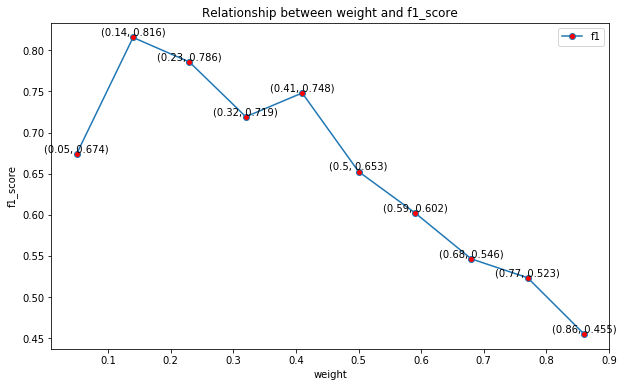

In [6]:
from pandas import Series,DataFrame
#构建my_f1_score和权重weight的dataframe
weight_f1 = {'weight':Series(weight),
            'f1':Series(my_f1_score)}
weight_f1 = DataFrame(weight_f1)

plt.figure(figsize=(10, 6))
plt.plot(weight_f1['weight'],weight_f1['f1'],marker='o',markerfacecolor='red')
plt.title('Relationship between weight and f1_score')
plt.xlabel('weight')
plt.ylabel('f1_score')

#设置数据标签
weight = Series([round(x,3) for x in weight])
my_f1_score = Series([round(x,3) for x in my_f1_score])
for a, b in zip(weight, my_f1_score):
    plt.text(a, b, (a,b), ha='center', va='bottom', fontsize=10)
plt.legend()

## 结论：当class=0的权重weight=0.14时，f1_score得分最高0.816，曲线有两个极大值，一个极小值，weight增大，f1_score整体呈现下滑趋势

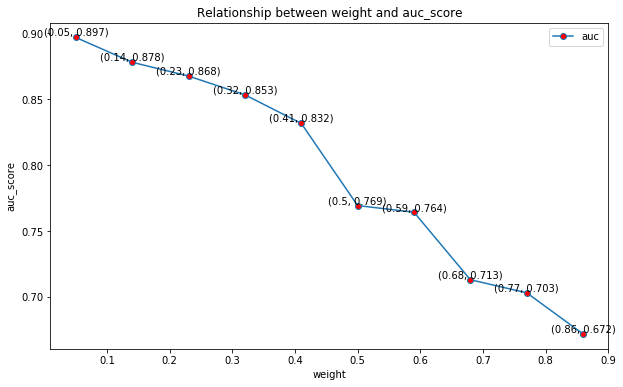

In [12]:
#构建my_auc_score和权重weight的dataframe
weight_auc = {'weight':Series(weight),
            'auc':Series(my_auc_score)}
weight_auc = DataFrame(weight_auc)

plt.figure(figsize=(10, 6))
plt.plot(weight_auc['weight'],weight_auc['auc'],marker='o',markerfacecolor='red')
plt.title('Relationship between weight and auc_score')
plt.xlabel('weight')
plt.ylabel('auc_score')

#设置数据标签
weight = Series([round(x,3) for x in weight])
my_auc_score = Series([round(x,3) for x in my_auc_score])
for a, b in zip(weight, my_auc_score):
    plt.text(a, b, (a,b), ha='center', va='bottom', fontsize=10)
plt.legend()

# 结论：当class=0的权重weight=0.05时，auc_score得分最高，auc_score整体随着weight增大呈下滑趋势

In [13]:
conf_matrix = confusion_matrix(y_true=target_test,y_pred = pred_results)
conf_matrix

array([[85280,    16],
       [   99,    48]], dtype=int64)

In [14]:
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
TP = conf_matrix[1][1]
print(TN,FP,FN,TP)

85280 16 99 48


# Accuray
\begin{array} \text{Accuracy}=\frac{\text{True Positives}+\text{True Negatives} }{\text{Total Number of Predictions}} \end{array}  

In [15]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_true=target_test,y_pred = pred_results)

# Precision
\begin{array} \text{Recall}=\frac{\text{True Positives}}{\text{True Positives}+\text{False Positives}}\end{array}


In [16]:
from sklearn.metrics import precision_score
prec_score = precision_score(y_true=target_test,y_pred = pred_results)

# Recall
\begin{array} \text{Precision}=\frac{\text{True Positives}}{\text{True Positives}+\text{False Positives}}\end{array}

In [17]:
from sklearn.metrics import recall_score
rec_score = recall_score(y_true=target_test,y_pred = pred_results)

# F1 Score
\begin{array} \tetx{F1}=\frac{2}{\frac{1}{\text { precision }}+\frac{1}{\text { recall }}}=\frac{2 * \text { (precision * recall) }}{\text { precision }+\text {recall}} \end{array}

In [81]:
from sklearn.metrics import f1_score
f1_score(y_true=target_test,y_pred = pred_results)

0.6742209631728046